In [348]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import seaborn as sns
import re
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Data Collection

In [300]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/module5/exercise/module5_exercise_test.csv


In [301]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [302]:
#### Make a complete analysis on data preprocessing
# Inconsistencies 数据类型或值不一致
# Duplicates (data.duplicated().sum()) 重复
# Missing values (data.isnull().sum()) 缺失值
# Categorical 分类变量及其分布
# Outliers 数值特征中的异常值
# Feature Engineering 特征工程的潜力
# Feature Selection and/or Dimensionality Reduction 特征选择或降维的机会

In [303]:
#pd.concat将df_train和df_test按（行）纵向拼接
data = pd.concat([df_train, df_test], axis=0)

In [304]:
df_train.shape

(1909, 16)

In [305]:
df_test.shape

(365, 15)

In [306]:
data.shape

(2274, 16)

In [307]:
#绘制指定特征在给定日期范围内的时间序列图
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45) #横轴刻度旋转 45 度，避免文字重叠
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [308]:
data['date'] = pd.to_datetime(data['date'])
#将 data 数据框中的 date 列转换为 datetime 类型

#### Detecting Inconsistencies

In [309]:
features = df_train.columns
print(features)

Index(['date', 'weather_condition', 'humidity', 'wind_speed',
       'oil_brent_price_indicator', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10',
       'electricity_demand'],
      dtype='object')


In [310]:
data_date = pd.DataFrame(data["date"])
print(data_date.applymap(lambda x: not re.match(r"\d{4}-\d{2}-\d{2}", str(x))).sum().sum())

0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10860\1009822844.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(data_date.applymap(lambda x: not re.match(r"\d{4}-\d{2}-\d{2}", str(x))).sum().sum())


In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 0 to 364
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       2274 non-null   datetime64[ns]
 1   weather_condition          2246 non-null   object        
 2   humidity                   2165 non-null   float64       
 3   wind_speed                 2167 non-null   object        
 4   oil_brent_price_indicator  2274 non-null   object        
 5   temperature_station1       1930 non-null   float64       
 6   temperature_station2       1946 non-null   float64       
 7   temperature_station3       1934 non-null   float64       
 8   temperature_station4       1954 non-null   float64       
 9   temperature_station5       1937 non-null   float64       
 10  temperature_station6       1953 non-null   float64       
 11  temperature_station7       1913 non-null   float64       
 12  temperature_

In [312]:
kmh_count=data['wind_speed'].str.contains('km/h').sum()
ms_count=data['wind_speed'].str.contains('m/s').sum()

print(f"Number of 'km/h' in wind_speed: {kmh_count}")
print(f"Number of 'm/s' in wind_speed: {ms_count}")

Number of 'km/h' in wind_speed: 1072
Number of 'm/s' in wind_speed: 1095


We should standardize the units in 'wind_speed'.

In [313]:
def convert_to_kmh(value:str):
    if not isinstance(value, str) or pd.isna(value):
        return None
    if 'km/h' in value:
        return float(value.split()[0])
    elif 'm/s' in value:
        return float(value.split()[0]) * 3.6
    else:
        return None

In [314]:
data['wind_speed'] = data['wind_speed'].apply(convert_to_kmh)

#### Detecting duplicates

In [315]:
exact_duplicates = data[data.duplicated()]
print(exact_duplicates)

           date weather_condition   humidity  wind_speed  \
6    2015-01-13            Cloudy  58.649834      28.750   
52   2015-02-27             Snowy  61.321278      11.610   
59   2015-03-05            Cloudy  54.187891       3.672   
129  2015-05-13             Rainy  73.325559       0.000   
141  2015-05-24            Cloudy  62.308585       9.010   
...         ...               ...        ...         ...   
1838 2019-10-26             Sunny  53.952131      15.480   
1875 2019-12-01             Snowy  72.532746      14.364   
1886 2019-12-11               NaN  61.201308      27.610   
1893 2019-12-17             Snowy  65.362283      18.756   
1906 2019-12-29             Rainy  68.085227      26.064   

     oil_brent_price_indicator  temperature_station1  temperature_station2  \
6                         High             -5.037719             -4.891658   
52                    Moderate             -0.765329             -1.089098   
59                    Very Low             11

In [316]:
def handle_duplicates(df):
    df_no_duplicates = df.drop_duplicates()
    return df_no_duplicates

In [317]:
data = handle_duplicates(data)

#### Detecting Missing Values

In [318]:
data = data.reset_index(drop=True)

In [319]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       2184 non-null   datetime64[ns]
 1   weather_condition          2159 non-null   object        
 2   humidity                   2080 non-null   float64       
 3   wind_speed                 2079 non-null   float64       
 4   oil_brent_price_indicator  2184 non-null   object        
 5   temperature_station1       1854 non-null   float64       
 6   temperature_station2       1868 non-null   float64       
 7   temperature_station3       1864 non-null   float64       
 8   temperature_station4       1880 non-null   float64       
 9   temperature_station5       1857 non-null   float64       
 10  temperature_station6       1878 non-null   float64       
 11  temperature_station7       1837 non-null   float64       
 12  temper

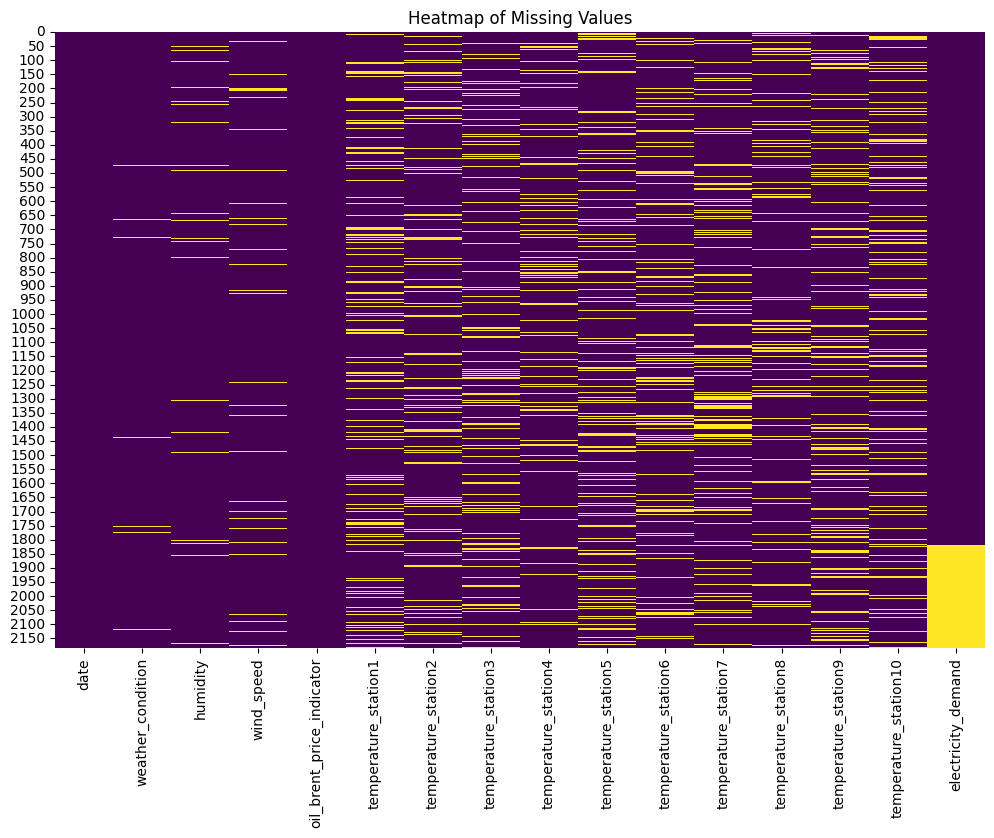

In [320]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

Except for the 'oil_brent_price_indicator' column, all other columns have missing values.

For the imputation of the categorical variable 'weather_condition', we decide to determine it based on its humidity.

After a preliminary observation, we need to first address the outliers in **humidity** and **electricity_demand**.

In [321]:
outlier_indice_humidity=data[data['humidity'] > 200].index
for i in outlier_indice_humidity:
    print(data.loc[i])

date                         2017-09-13 00:00:00
weather_condition                          Sunny
humidity                                 50000.0
wind_speed                                 8.496
oil_brent_price_indicator               Moderate
temperature_station1                   10.099884
temperature_station2                   10.032461
temperature_station3                    9.922033
temperature_station4                         NaN
temperature_station5                    9.979347
temperature_station6                   10.751949
temperature_station7                         NaN
temperature_station8                     9.30438
temperature_station9                         NaN
temperature_station10                   9.392699
electricity_demand                    219.769584
Name: 979, dtype: object
date                         2018-12-18 00:00:00
weather_condition                          Rainy
humidity                                 50000.0
wind_speed                                16

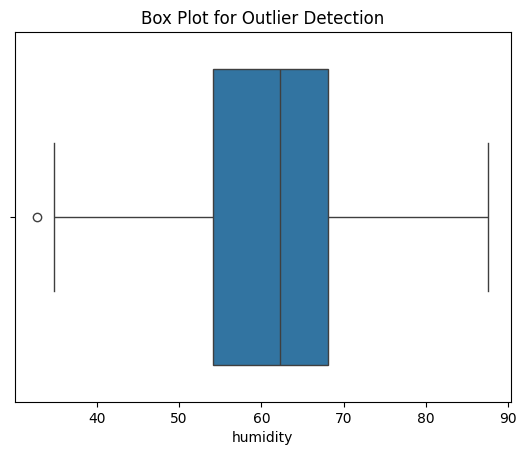

In [322]:
valid_mean_sunny = data[(data['weather_condition'] == 'Sunny') & (data['humidity'] <= 1000)]['humidity'].mean()
data.loc[(data['weather_condition'] == 'Sunny') & (data['humidity'] > 1000), 'humidity'] = valid_mean_sunny

valid_mean_rainy = data[(data['weather_condition'] == 'Rainy') & (data['humidity'] <= 1000)]['humidity'].mean()
data.loc[(data['weather_condition'] == 'Rainy') & (data['humidity'] > 1000), 'humidity'] = valid_mean_rainy

sns.boxplot(x=data['humidity'])
plt.title('Box Plot for Outlier Detection')
plt.show()

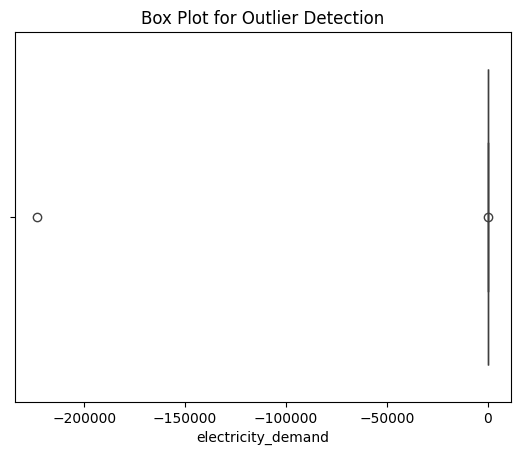

In [323]:
sns.boxplot(x=data['electricity_demand'])
plt.title('Box Plot for Outlier Detection')
plt.show()

In [324]:
data.loc[data['electricity_demand'] <= 0, 'electricity_demand'] = abs(data['electricity_demand'])/1000

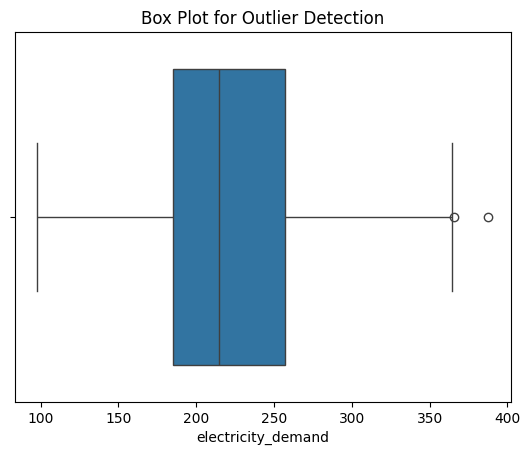

In [325]:
sns.boxplot(x=data['electricity_demand'])
plt.title('Box Plot for Outlier Detection')
plt.show()

Now we can start handling the missing values.

In [326]:
def fill_weather_condition(weather_series):
    weather_series = weather_series.copy()  # 避免修改原数据
    n = len(weather_series)
    
    i = 0
    while i < n:
        if pd.isna(weather_series.iloc[i]):  # 如果当前值是缺失值
            start = i  # 记录缺失值的起始位置
            
            # 找到连续缺失值的结束位置
            while i < n and pd.isna(weather_series.iloc[i]):
                i += 1
            end = i  # 连续缺失值的结束位置（不包含）
            
            # 获取前后值
            prev_value = weather_series.iloc[start - 1] if start > 0 else None
            next_value = weather_series.iloc[end] if end < n else None
            
            # 填充逻辑
            if prev_value == next_value and pd.notna(prev_value):
                # 前后值相同，填充相同值
                weather_series.iloc[start:end] = prev_value
            elif pd.notna(prev_value) and pd.notna(next_value):
                # 前后值不同，随机选择一个值填充
                weather_series.iloc[start:end] = np.random.choice([prev_value, next_value])
            elif pd.notna(prev_value):
                # 只有前值存在，用前值填充
                weather_series.iloc[start:end] = prev_value
            elif pd.notna(next_value):
                # 只有后值存在，用后值填充
                weather_series.iloc[start:end] = next_value
        else:
            i += 1  # 非缺失值，继续向后遍历
    
    return weather_series


In [327]:
data['weather_condition'] = fill_weather_condition(data['weather_condition'])

In [328]:
# 按 weather_condition 分组，计算 humidity 的均值
weather_condition_mean = data.groupby('weather_condition')['humidity'].mean()

# 用对应的均值填补缺失值
data['humidity'] = data.apply(
    lambda row: weather_condition_mean[row['weather_condition']] if pd.isna(row['humidity']) else row['humidity'],
    axis=1
)

In [329]:
# 按 weather_condition 分组，计算 wind_speed 的均值
weather_condition_mean_wind_speed = data.groupby('weather_condition')['wind_speed'].mean()

# 用对应的均值填补 wind_speed 的缺失值
data['wind_speed'] = data.apply(
    lambda row: weather_condition_mean_wind_speed[row['weather_condition']] if pd.isna(row['wind_speed']) else row['wind_speed'],
    axis=1
)

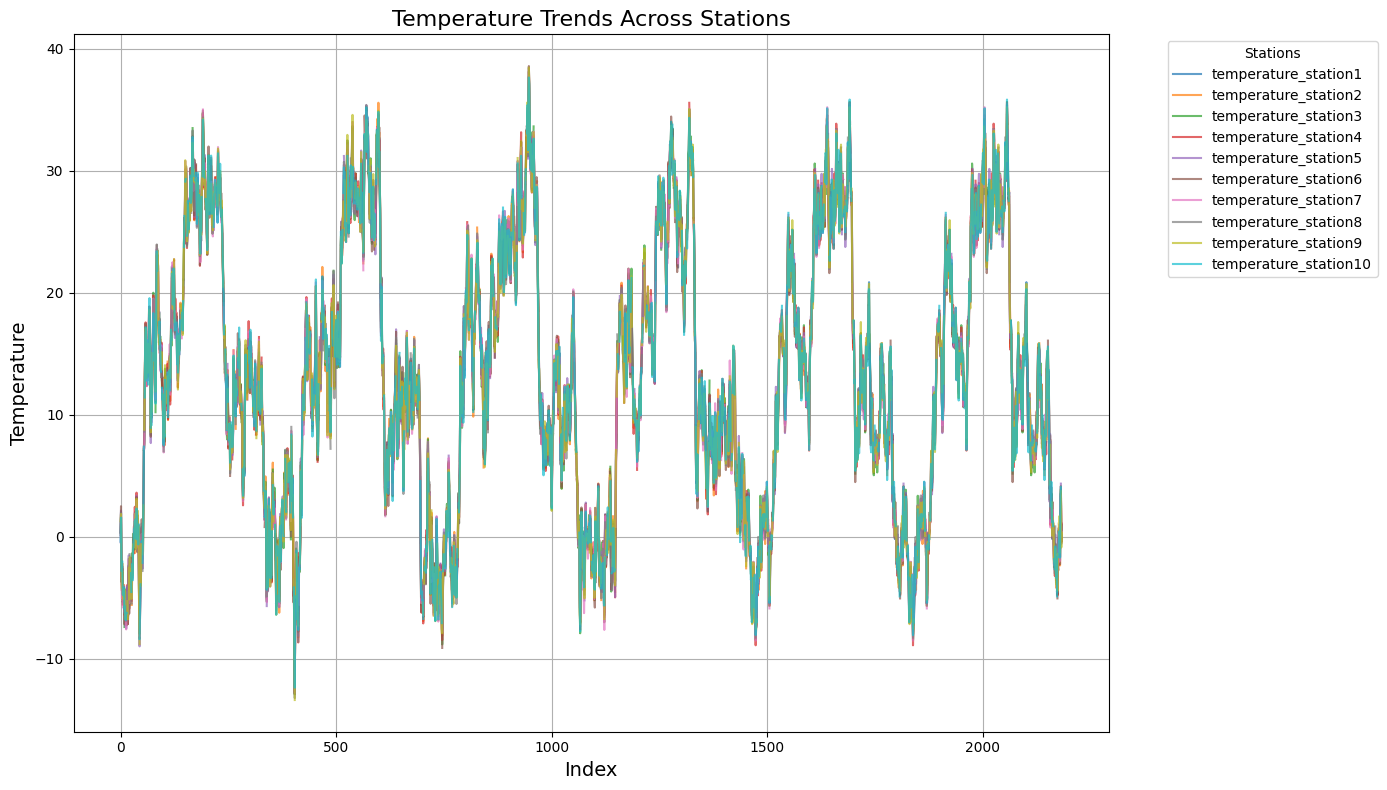

In [330]:
# 提取 temperature_station1 到 temperature_station10 的列名
temperature_columns = [f'temperature_station{i}' for i in range(1, 11)]

# 绘制折线图
plt.figure(figsize=(14, 8))
for col in temperature_columns:
    plt.plot(data.index, data[col], label=col, alpha=0.7)  # 添加透明度以区分线条

# 设置图表标题和轴标签
plt.title('Temperature Trends Across Stations', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [331]:
# 将 date 列设置为索引
data = data.set_index('date')

# 使用时间插值填补缺失值
for col in [f'temperature_station{i}' for i in range(1, 11)]:
    data[col] = data[col].interpolate(method='time')

# 如果需要恢复索引
data = data.reset_index()

In [332]:
# 获取除了 temperature_station2 的其他列名
stations = [f'temperature_station{i}' for i in range(1, 11) if i != 2]

# 计算其他站点的均值并填补 temperature_station2 前两个缺失值
data.loc[:1, 'temperature_station2'] = data.loc[:1, stations].mean(axis=1)

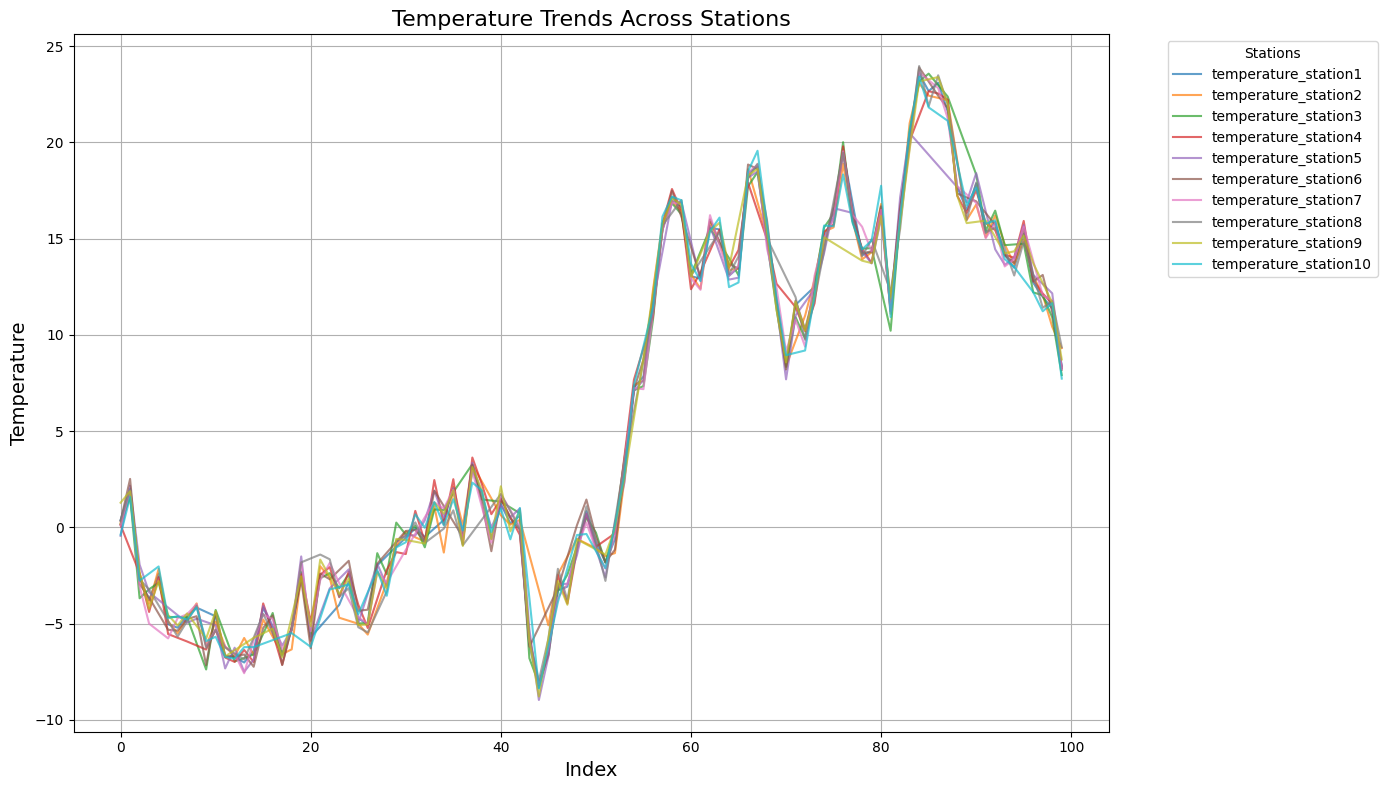

In [333]:
plt.figure(figsize=(14, 8))
for col in temperature_columns:
    plt.plot(data.index[0:100], data[col][0:100], label=col, alpha=0.7)  # 添加透明度以区分线条

# 设置图表标题和轴标签
plt.title('Temperature Trends Across Stations', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [334]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       2184 non-null   datetime64[ns]
 1   weather_condition          2184 non-null   object        
 2   humidity                   2184 non-null   float64       
 3   wind_speed                 2184 non-null   float64       
 4   oil_brent_price_indicator  2184 non-null   object        
 5   temperature_station1       2184 non-null   float64       
 6   temperature_station2       2184 non-null   float64       
 7   temperature_station3       2184 non-null   float64       
 8   temperature_station4       2184 non-null   float64       
 9   temperature_station5       2184 non-null   float64       
 10  temperature_station6       2184 non-null   float64       
 11  temperature_station7       2184 non-null   float64       
 12  temper

#### Detecting Outliers

In [335]:
print(data.dtypes)

date                         datetime64[ns]
weather_condition                    object
humidity                            float64
wind_speed                          float64
oil_brent_price_indicator            object
temperature_station1                float64
temperature_station2                float64
temperature_station3                float64
temperature_station4                float64
temperature_station5                float64
temperature_station6                float64
temperature_station7                float64
temperature_station8                float64
temperature_station9                float64
temperature_station10               float64
electricity_demand                  float64
dtype: object


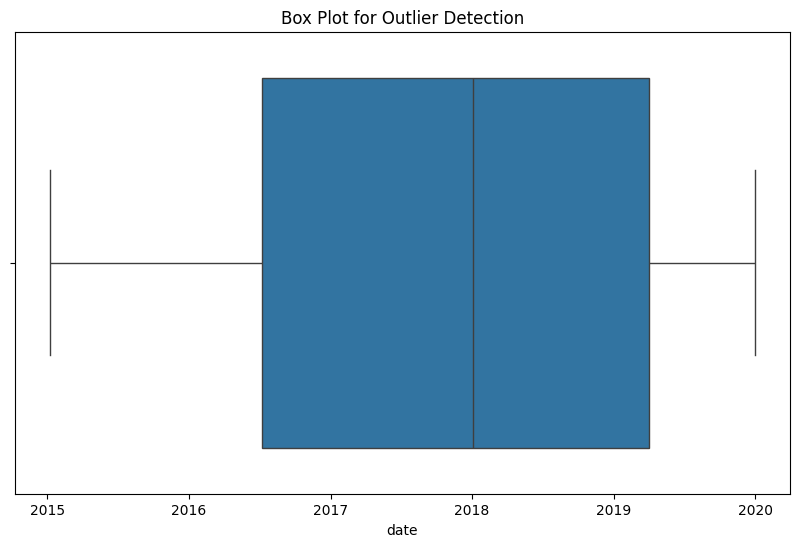

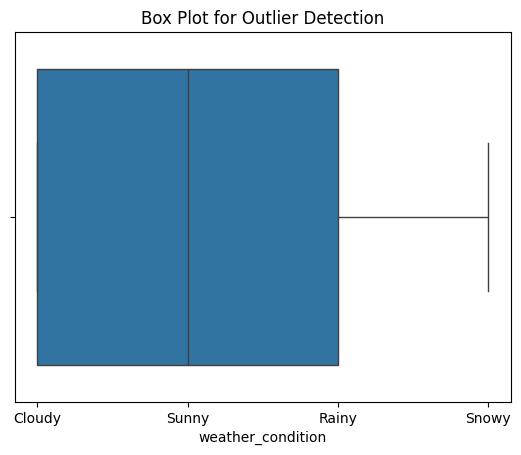

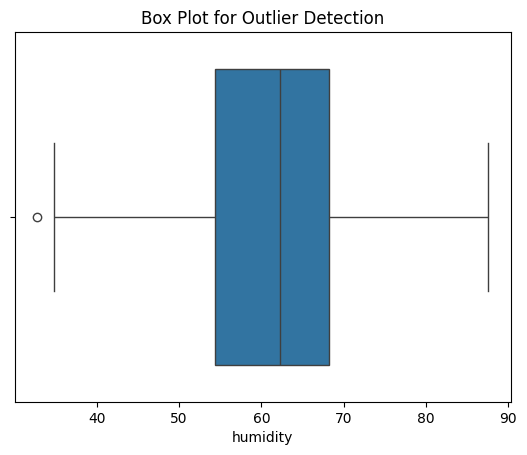

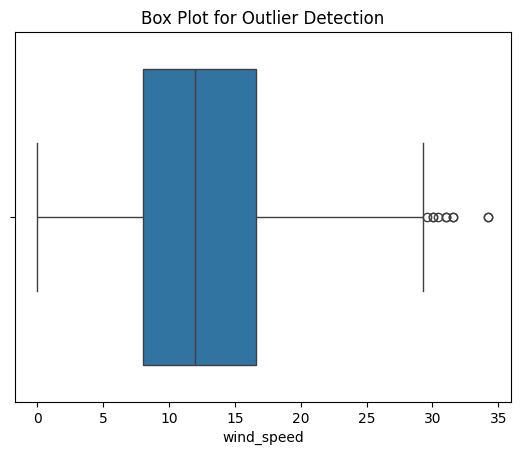

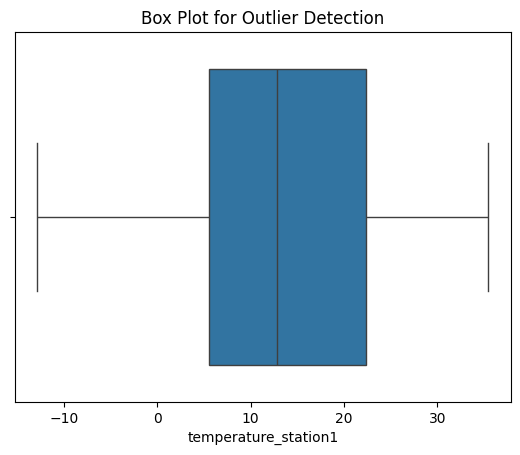

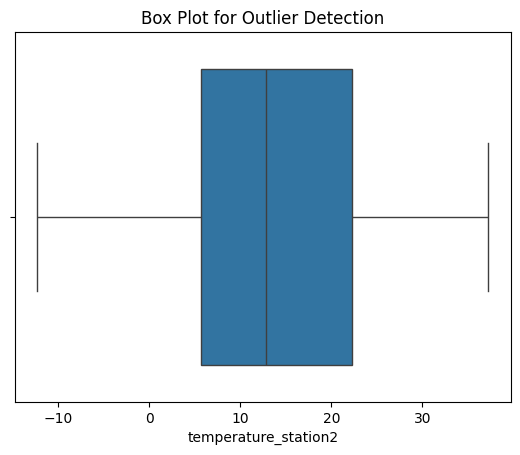

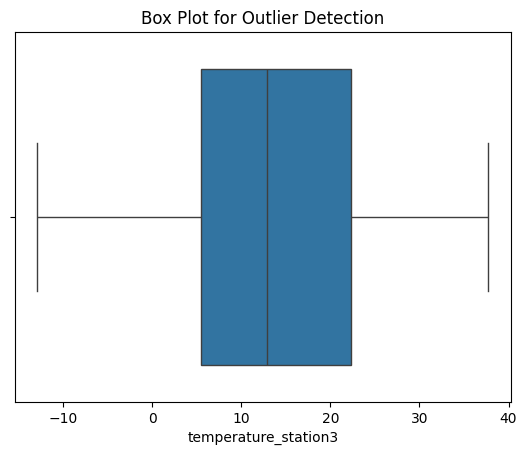

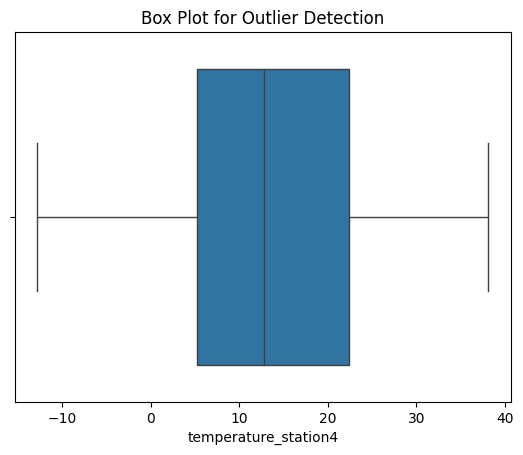

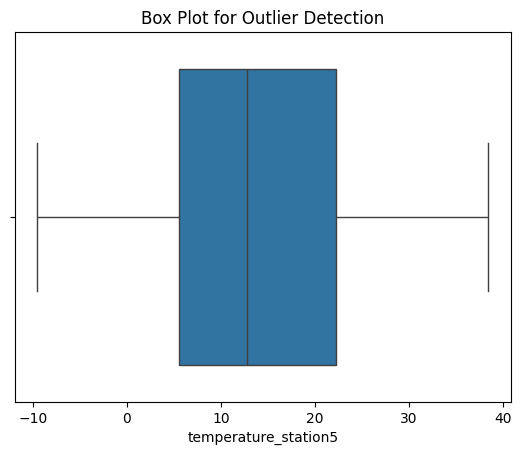

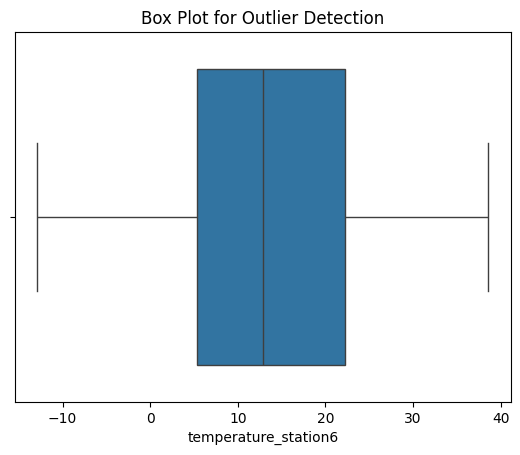

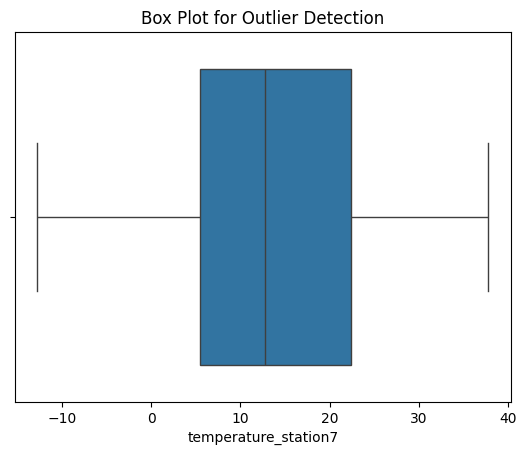

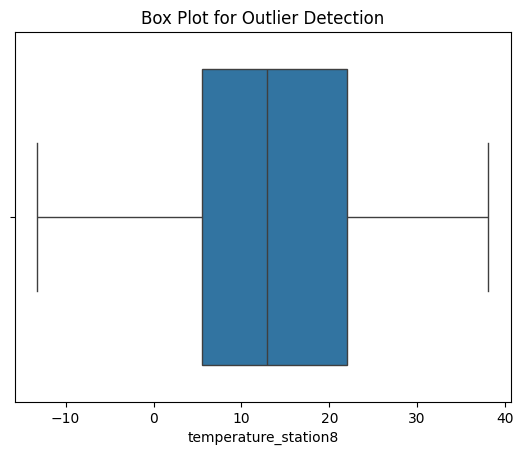

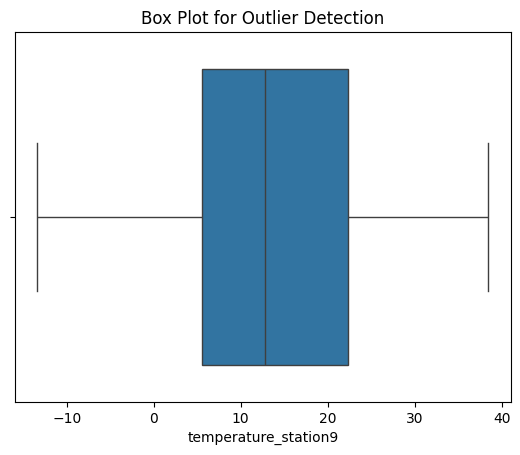

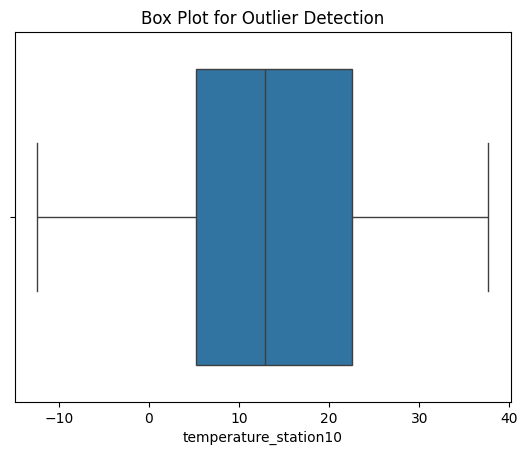

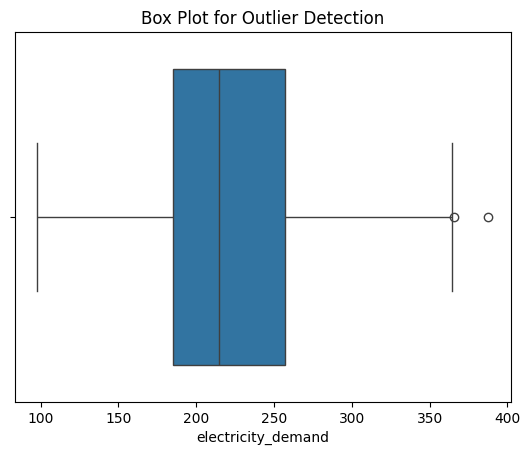

In [336]:
plt.figure(figsize=(10, 6))
for column in data.columns:
    if column != 'oil_brent_price_indicator':
        sns.boxplot(x=data[column])
        plt.title('Box Plot for Outlier Detection')
        plt.show()

#### Detecting Categorical Values

For the two categorical variables, `oil_brent_price_indicator` and `weather_condition`, we will convert them into numerical variables.

In [337]:
data_encoded = pd.get_dummies(data, columns=['oil_brent_price_indicator', 'weather_condition'])
bool_columns = data_encoded.select_dtypes(include=['bool']).columns
data_encoded[bool_columns] = data_encoded[bool_columns].astype(float)

data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2184 non-null   datetime64[ns]
 1   humidity                             2184 non-null   float64       
 2   wind_speed                           2184 non-null   float64       
 3   temperature_station1                 2184 non-null   float64       
 4   temperature_station2                 2184 non-null   float64       
 5   temperature_station3                 2184 non-null   float64       
 6   temperature_station4                 2184 non-null   float64       
 7   temperature_station5                 2184 non-null   float64       
 8   temperature_station6                 2184 non-null   float64       
 9   temperature_station7                 2184 non-null   float64       
 10  temperature_

#### Feature Engineering

##### DateTime Decomposition

In [338]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

# 检查处理结果
print(data[['date', 'year', 'month', 'day', 'hour']].head())


        date  year  month  day  hour
0 2015-01-08  2015      1    8     0
1 2015-01-09  2015      1    9     0
2 2015-01-10  2015      1   10     0
3 2015-01-11  2015      1   11     0
4 2015-01-12  2015      1   12     0


##### Domain-Specific Feature Extraction

In [339]:
for i in range(1, 11):
    station_col = f'temperature_station{i}'
    feel_col = f'temperature_feel_station{i}'
    data[feel_col] = data[station_col] - 0.55 * (1 - data['humidity'] / 100) * (data[station_col] - 14.5)

# 检查结果
feel_columns = [f'temperature_feel_station{i}' for i in range(1, 11)]
print(data[feel_columns].head())

   temperature_feel_station1  temperature_feel_station2  \
0                   2.755021                   2.622270   
1                   5.035531                   4.728881   
2                   0.905097                   1.049397   
3                   0.196205                   0.052135   
4                   0.649628                   0.849854   

   temperature_feel_station3  temperature_feel_station4  \
0                   2.580945                   2.546241   
1                   4.737989                   2.650891   
2                   0.044840                   1.072962   
3                   0.643772                  -0.278747   
4                   0.260264                   0.500783   

   temperature_feel_station5  temperature_feel_station6  \
0                   2.078556                   2.708694   
1                   5.149315                   5.418747   
2                   1.435140                   0.629449   
3                   0.520486                   0.30521

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        2184 non-null   datetime64[ns]
 1   weather_condition           2184 non-null   object        
 2   humidity                    2184 non-null   float64       
 3   wind_speed                  2184 non-null   float64       
 4   oil_brent_price_indicator   2184 non-null   object        
 5   temperature_station1        2184 non-null   float64       
 6   temperature_station2        2184 non-null   float64       
 7   temperature_station3        2184 non-null   float64       
 8   temperature_station4        2184 non-null   float64       
 9   temperature_station5        2184 non-null   float64       
 10  temperature_station6        2184 non-null   float64       
 11  temperature_station7        2184 non-null   float64     

#### Feature Selection and Dimensionality Reduction

In [341]:
print(data.columns)

Index(['date', 'weather_condition', 'humidity', 'wind_speed',
       'oil_brent_price_indicator', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10',
       'electricity_demand', 'year', 'month', 'day', 'hour',
       'temperature_feel_station1', 'temperature_feel_station2',
       'temperature_feel_station3', 'temperature_feel_station4',
       'temperature_feel_station5', 'temperature_feel_station6',
       'temperature_feel_station7', 'temperature_feel_station8',
       'temperature_feel_station9', 'temperature_feel_station10'],
      dtype='object')


In [342]:
data_with_demand = data[data['electricity_demand'].notna()].copy()
data_without_demand = data[data['electricity_demand'].isna()].copy()

In [344]:
X=data_with_demand.drop(columns=['electricity_demand','date','weather_condition','oil_brent_price_indicator'])
y=data_with_demand['electricity_demand']

selector = SelectKBest(f_classif, k=5)  # Select top 5 features
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)
feature_names = X.columns[selected_features]
print("Selected features:", feature_names)

Selected features: Index(['temperature_feel_station6', 'temperature_feel_station7',
       'temperature_feel_station8', 'temperature_feel_station9',
       'temperature_feel_station10'],
      dtype='object')


d:\Anaconda3\envs\stat\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


In [349]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

# 模型训练
model.fit(X_train, y_train)

# 模型预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算误差
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 输出结果
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Train MSE: 75.7237
Test MSE: 533.8397


### Data Preprocessing Evaluation Strategy

In [ ]:
# Provide a complete data preprocessing transformations

In [ ]:
# # 1. Handle Inconsistencies
# def handle_inconsistencies(X_train, y_train):
#     X_train_no_inconsistencies = X_train.copy()
#     X_train_no_inconsistencies['date'] =pd.to_datetime(X_train['date'])
#     X_train_no_inconsistencies['wind_speed'] = X_train_no_inconsistencies['wind_speed'].apply(convert_to_kmh)
#     return X_train_no_inconsistencies, y_train.copy()

# # 2. Handling Duplicates
# def handle_duplicates_2(X_train, y_train, X_val=None):
#     X_train_no_duplicates = X_train.drop_duplicates()
#     y_train_no_duplicates = y_train[X_train_no_duplicates.index]
#     return X_train_no_duplicates, y_train_no_duplicates

# # 3. Handling Outliers
# def handle_outliers(X_train, y_train, X_val=None):
#     if X_val is not None:
#         #humidity
#         valid_mean_sunny_def = X_train[(X_train['weather_condition'] == 'Sunny') & (X_train['humidity'] <= 1000)]['humidity'].mean()
#         X_train.loc[(X_train['weather_condition'] == 'Sunny') & (X_train['humidity'] > 1000), 'humidity'] = valid_mean_sunny_def

#         valid_mean_rainy_def = X_train[(X_train['weather_condition'] == 'Rainy') & (X_train['humidity'] <= 1000)]['humidity'].mean()
#         X_train.loc[(X_train['weather_condition'] == 'Rainy') & (X_train['humidity'] > 1000), 'humidity'] = valid_mean_rainy_def

#         #electricity_demand
#         X_train.loc[X_train['electricity_demand'] <= 0, 'electricity_demand'] = abs(X_train['electricity_demand'])/1000

#         return X_train.copy(), y_train, X_val.copy()
#     else:
#         return X_train.copy(), y_train

# # 4. Handling Missing Values
# def handle_missing_values(X_train, y_train, X_val=None):
#     if X_val is not None:
#         X_train['weather_condition'] = X_train['weather_condition'].apply(fill_weather_condition).fillna(-1)
#         X_val = X_val.fillna(-1)
#         return X_train.copy(), X_val.copy()
#     else:
#         X_train['weather_condition'] = X_train['weather_condition'].apply(fill_weather_condition).fillna(-1)
#         return X_train
    
# # 5. Handling Categorical Values
# def handle_categorical(X_train, y_train, X_val=None):
#     if X_val is not None:
#         return X_train.copy(), X_val.copy()
#     else:
#         return X_train.copy()

# # 6. Feature Engineering
# def feature_engineering(X_train, y_train, X_val=None):
#     if X_val is not None:
#         return X_train.copy(), y_train, X_val.copy()
#     else:
#         return X_train.copy(), y_train

# # 7. Feature Selection and Dimensionality Reduction
# def feature_selection(X_train, y_train, X_val=None):
#     selected_columns = ['humidity', 'temperature_station1',
#        'temperature_station2', 'temperature_station3', 'temperature_station4',
#        'temperature_station5', 'temperature_station6', 'temperature_station7',
#        'temperature_station8', 'temperature_station9', 'temperature_station10']
#     if X_val is not None:
#         return X_train[selected_columns], X_val[selected_columns]
#     else:
#         return X_train[selected_columns]

In [ ]:
# def evaluate_pipeline(X, y, n_splits=5):

#     ### call transformations here, if there is no learning and no need to be crossval
#     X, y = handle_inconsistencies(X, y)
#     # X, y = handle_duplicates(X, y)
#     X  = handle_missing_values(X, y)
#     # X_train = handle_categorical(X, y)
#     X, y = handle_outliers(X, y)
#     # X, y = feature_engineering(XX, y)
#     X = feature_selection(X, y)
    
#     model = LinearRegression()
    
#     tscv = TimeSeriesSplit(n_splits=n_splits)
    
#     train_scores = []
#     val_scores = []
    
#     for fold, (train_index, val_index) in enumerate(tscv.split(X)):
#         print(f"Processing fold {fold + 1}/{n_splits}...")
        
#         # Split data into train and validation sets
#         X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
#         y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

#         ### call transformations here, if there is learning
#         # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
#         X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
#         # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
#         X_train, X_val = handle_categorical(X_train, y_train, X_val)
#         # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
#         X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
#         # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
#         # Train the model
#         model.fit(X_train, y_train)
        
#         # Predict on training set
#         y_train_pred = model.predict(X_train)
#         train_mse = mean_squared_error(y_train, y_train_pred)
#         train_scores.append(train_mse)
        
#         # Predict on validation set
#         y_val_pred = model.predict(X_val)
#         val_mse = mean_squared_error(y_val, y_val_pred)
#         val_scores.append(val_mse)
        
#         print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
#     # Compute mean, max, and min values for train and validation MSE
#     mean_train_mse = np.mean(train_scores)
#     max_train_mse = np.max(train_scores)
#     min_train_mse = np.min(train_scores)
    
#     mean_val_mse = np.mean(val_scores)
#     max_val_mse = np.max(val_scores)
#     min_val_mse = np.min(val_scores)
    
#     # Print results
#     print("\nTrain MSE:")
#     print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
#     print("\nValidation MSE:")
#     print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
#     return mean_val_mse  # Return mean validation MSE as the overall score

In [ ]:
# # Prepare X and y
# X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
# y = df_train.copy().pop('electricity_demand')

# # Run the evaluation
# evaluate_pipeline(X, y)

### Generating Submission File

In [ ]:
# Train and submit your results

In [ ]:
# # Prepare X_train and y_train from your data
# df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

# X_train = df_train.drop(columns=['electricity_demand'], axis=1)
# y_train = df_train['electricity_demand']

# X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [ ]:
# def train_and_predict_to_submit(X_train, y_train, X_test):
#     model = LinearRegression()
    
#     X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
#     X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
#     X_train, X_test = handle_missing_values(X_train, y_train, X_test)
#     X_train, X_test = handle_categorical(X_train, y_train, X_test)
#     X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
#     X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
#     X_train, X_test = feature_selection(X_train, y_train, X_test)

#     # Train the model on the entire training set
#     print(f"Training model on entire dataset of shape: {X_train.shape}")
#     model.fit(X_train, y_train)
    
#     # Predict on the test set
#     print(f"Predicting on test dataset of shape: {X_test.shape}")
#     y_test_pred = model.predict(X_test)
    
#     return y_test_pred

In [355]:
# Call serve_model to train and predict
X_test_after_pocess=data_without_demand.drop(columns=['electricity_demand','date','weather_condition','oil_brent_price_indicator'])
y_test_pred = model.predict(X_test_after_pocess)

In [357]:
# Generating Submission File
submission = pd.DataFrame({
    'date': data_without_demand['date'],
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
